# Visualise "ground truth" dataset

In [9]:
import os

OUTPUT_PATH = "../plots/png"

# make output folder if needed
os.makedirs(OUTPUT_PATH, exist_ok=True)

### Checking all keys in dataset and their format

In [27]:
import h5py

with h5py.File("../../data/dataset.h5", 'r') as f:
    print("\nKeys found in the HDF5 file:")
    for key in f.keys():
        data = f[key]
        print(f"- {key} : shape={data.shape}, dtype={data.dtype}")


Keys found in the HDF5 file:
- ID_Parcelles : shape=(14836, 24, 24), dtype=float32
- coords : shape=(14836, 2), dtype=float64
- data : shape=(14836, 12, 4, 24, 24), dtype=float32
- dates : shape=(14836,), dtype=object
- labels : shape=(14836, 24, 24), dtype=float32
- zones : shape=(14836,), dtype=object


### Load useful keys for visualisation computation

In [ ]:
with h5py.File("../../data/dataset.h5", 'r') as f:
    data = f['data'][:]
    labels = f['labels'][:]
    coords = f['coords'][:]
    dates = f['dates'][:]

labels

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [25.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 14., 14., 14.],
        [ 0.,  0.,  0., ..., 14., 14., 14.],
        [ 0.,  0.,  0., ..., 14., 14., 14.],
        ...,
        [ 0.,  0.,  0., ..., 14., 14., 14.],
        [ 0.,  0.,  0., ..., 14., 14., 14.],
        [ 0.,  0.,  0., ..., 14., 14., 14.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.

## Visualisation part

### Label distribution

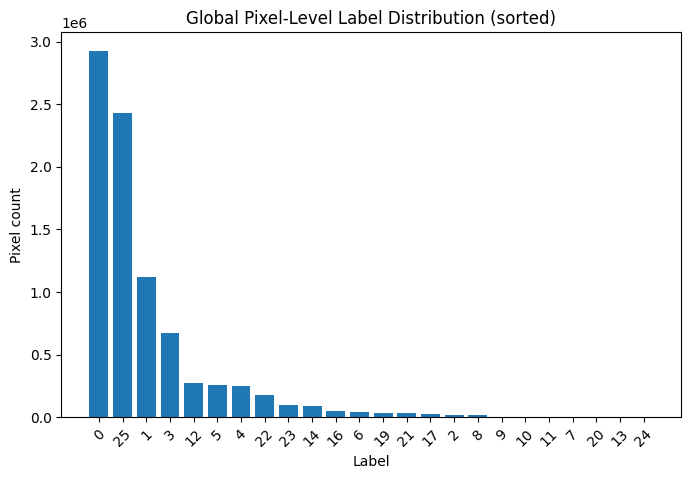

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# flatten all pixel labels
flat = labels.ravel()
uniq, counts = np.unique(flat, return_counts=True)

# sort by counts descending
sort_idx = np.argsort(counts)[::-1]
uniq_sorted  = uniq[sort_idx]
counts_sorted = counts[sort_idx]

# convert labels to strings for ticks
label_strs = uniq_sorted.astype(int).astype(str)

plt.figure(figsize=(8, 5))
plt.bar(label_strs, counts_sorted)
plt.xlabel('Label')
plt.ylabel('Pixel count')
#plt.yscale('log') # Help to see low represented labels
plt.title('Global Pixel-Level Label Distribution (sorted)')
plt.xticks(rotation=45)
#plt.savefig(OUTPUT_PATH+"/label_distribution.png")
plt.show()
plt.close()


### Patchs example with RGBI bands and True Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0955752].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1384616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0617608].


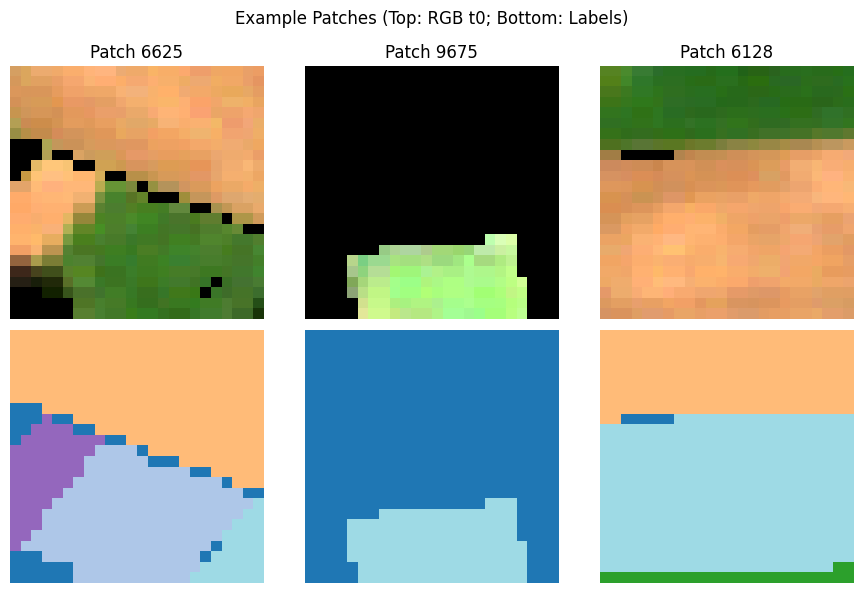

In [ ]:
n_examples=3

N, T, B, H, W = data.shape

picks = np.random.choice(N, size=n_examples, replace=False)
fig, axes = plt.subplots(2, n_examples, figsize=(n_examples*3, 6))
for i, idx in enumerate(picks):
    # RGB at first time
    patch = data[idx, 0]  # (B, H, W)
    rgb = np.stack([patch[2], patch[1], patch[0]], axis=-1)
    axes[0,i].imshow(rgb / np.percentile(rgb,98))
    axes[0,i].axis('off')
    axes[0,i].set_title(f'Patch {idx}')
    # label map
    axes[1,i].imshow(labels[idx], cmap='tab20')
    axes[1,i].axis('off')
fig.suptitle('Example Patches (Top: RGB t0; Bottom: Labels)')
plt.tight_layout()
plt.savefig(OUTPUT_PATH+"/patch_example.png")
plt.show()
plt.close()


### Band value distribution

It's helpfull to control :
- Pixel distribution for each band
- If there is no saturated band
- If we need to normalised values or if it's well distributed
- Detect some artefact or missing value

*X-axis correspond to every pixels (flatten), Y-axis correspond to the value of corresponding pixel for this particular band.*

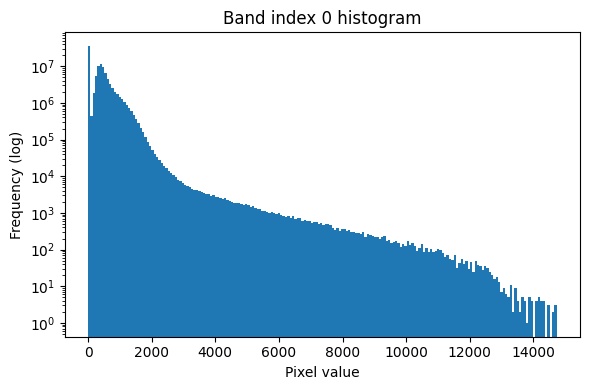

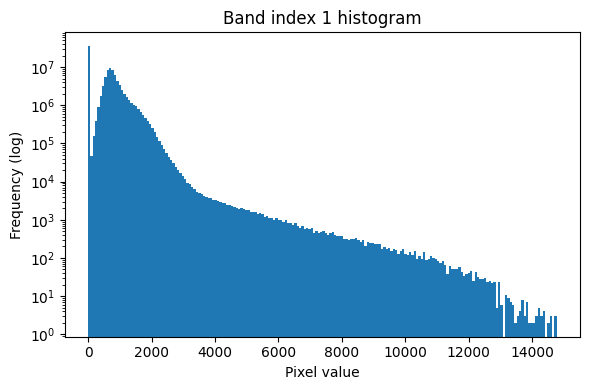

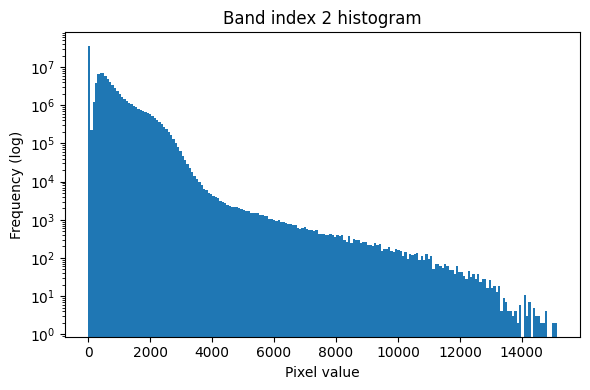

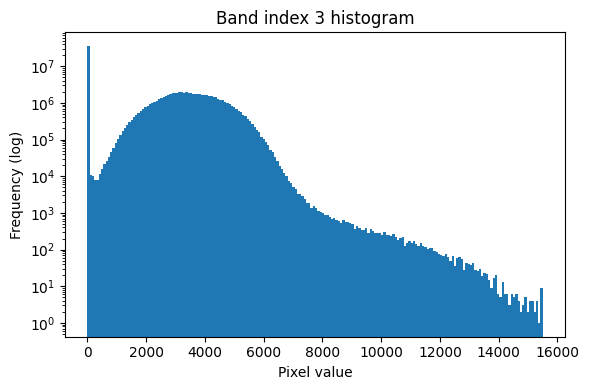

In [25]:
# flatten per band over all samples and times
_, T, B, H, W = data.shape
for b in range(B):
    vals = data[:, :, b].ravel()
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=200, log=True)
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency (log)')
    plt.title(f'Band index {b} histogram')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'band_{b}_hist.png'))
    plt.show()
    plt.close()


### Compute NDVI for few random patches

**NDVI** stands for **Normalized Difference Vegetation Index**. 
It's a commonly used indicator in remote sensing to measure vegetation health.

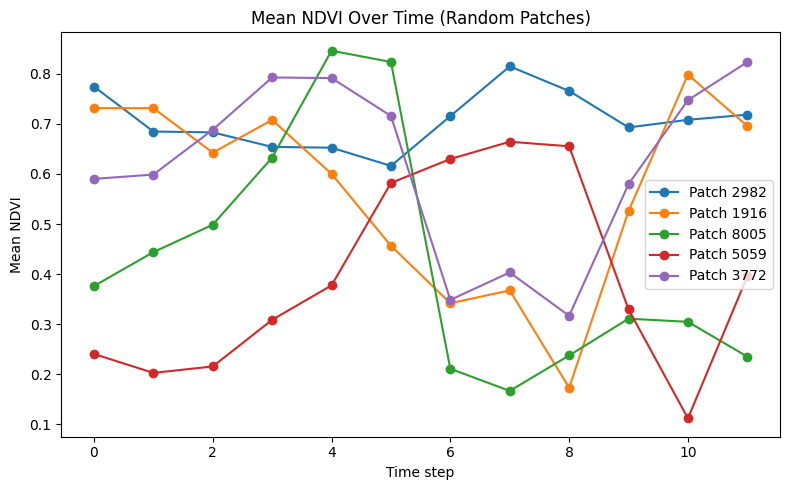

In [ ]:
# NDVI = (B8 - B4)/(B8 + B4) = (band 3 - band 2)/(band 3 + band 2) zero-based
N, T, B, H, W = data.shape
n_profiles = 5

picks = np.random.choice(N, size=n_profiles, replace=False)
time_axis = np.arange(T)  # [0, 1, ..., 11]

plt.figure(figsize=(8, 5))
for idx in picks:
    patch = data[idx]  # shape (T, B, H, W)
    B4 = patch[:, 2].mean(axis=(1, 2))  # Red
    B8 = patch[:, 3].mean(axis=(1, 2))  # NIR
    ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
    plt.plot(time_axis, ndvi, marker='o', label=f'Patch {idx}')

plt.xlabel('Time step')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI Over Time (Random Patches)')
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_PATH+"/ndvi.png")
plt.show()
plt.close()

In [41]:
import pandas as pd

zones_stats_df = pd.read_excel("../../data/sats_selected_regions.xlsx")
zones_stats_df


,Unnamed: 0,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,geometry,LEVEL_1,Label_names,LEVEL_2,Labels_ID,source_FID
0,0,4042,0.30,PPH,18,NaN,NaN,MULTIPOLYGON (((3.274769144178992 49.978546315...,grassland,meadow,meadow,6.0,0
1,1,6063,1.39,PPH,18,NaN,NaN,MULTIPOLYGON (((3.2810346132360717 49.96516714...,grassland,meadow,meadow,6.0,0
2,2,25920,11.63,ORP,3,NaN,NaN,MULTIPOLYGON (((3.315188823956375 49.981678610...,Field Crops,Barley,small_grain_cereal,36.0,0
3,3,49677,10.46,BTH,1,NaN,NaN,MULTIPOLYGON (((3.287163043167062 49.953910712...,Field Crops,Winter_Wheat,small_grain_cereal,8.0,0
4,4,52760,7.39,BTN,24,NaN,NaN,MULTIPOLYGON (((3.217246640029294 50.003851472...,Field Crops,Beet,Broad_Leaf_Row_Crop,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134492,134492,9856290,0.66,VRC,21,NaN,NaN,MULTIPOLYGON (((2.880067303184325 43.211052533...,Orchards,Vineyard,Vine,43.0,40
134493,134493,9856966,0.06,SNE,28,NaN,NaN,MULTIPOLYGON (((2.8410884213662353 43.27412006...,NaN,NaN,NaN,0.0,40
134494,134494,9861218,1.60,VRC,21,NaN,NaN,MULTIPOLYGON (((2.8943559377119876 43.26316098...,Orchards,Vineyard,Vine,43.0,40
134495,134495,9864163,0.02,SNE,28,NaN,NaN,MULTIPOLYGON (((2.9093087505999975 43.21859198...,NaN,NaN,NaN,0.0,40


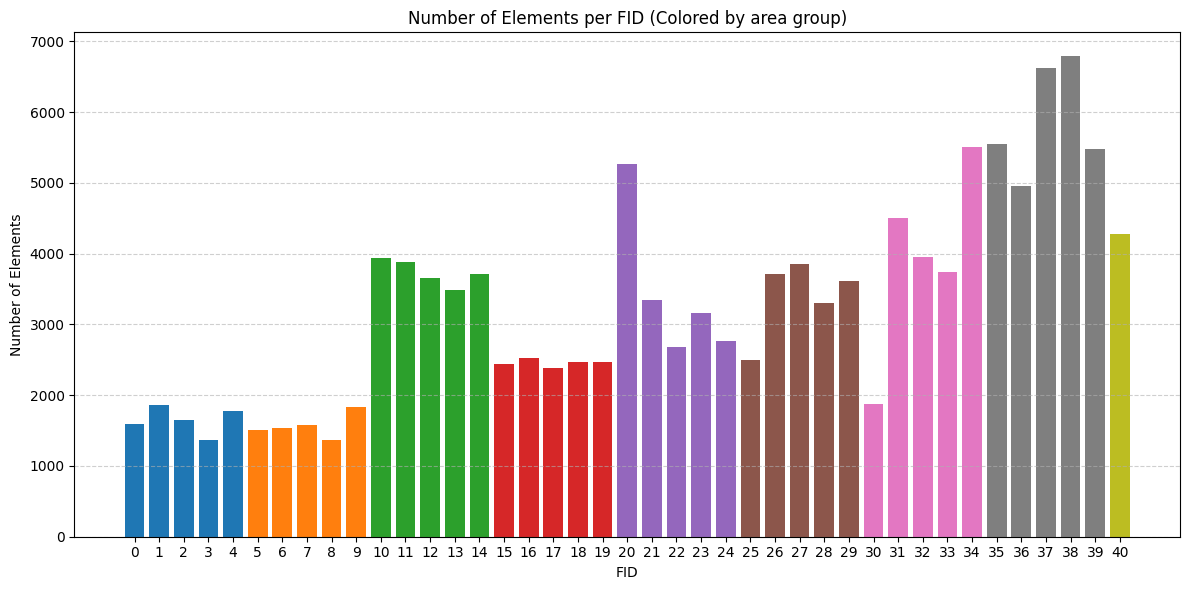

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the occurrences of each FID (including missing ones)
fid_range = range(0, 41)  # FID from 0 to 40
fid_counts = zones_stats_df['source_FID'].value_counts().reindex(fid_range, fill_value=0)

# Define colors for each group of 5 FIDs
colors = []
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']  # 9 color options
for fid in fid_counts.index:
    color_group = fid // 5
    colors.append(color_palette[color_group % len(color_palette)])

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(fid_counts.index, fid_counts.values, color=colors)
plt.title("Number of Elements per FID (Colored by area group)")
plt.xlabel("FID")
plt.ylabel("Number of Elements")
plt.xticks(fid_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [57]:
from shapely import wkt
from shapely.ops import transform
import pyproj

# Convert WKT strings to shapely geometry objects
zones_stats_df["geometry"] = zones_stats_df["geometry"].apply(wkt.loads)

# Define a projection: WGS84 (EPSG:4326) -> Lambert 93 (EPSG:2154, used in France)
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True).transform

# Compute area in square meters
zones_stats_df["surface"] = zones_stats_df["geometry"].apply(
    lambda geom: transform(project, geom).area
)

zones_stats_df

,Unnamed: 0,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,geometry,LEVEL_1,Label_names,LEVEL_2,Labels_ID,source_FID,surface
0,0,4042,0.30,PPH,18,NaN,NaN,MULTIPOLYGON (((3.274769144178992 49.978546315...,grassland,meadow,meadow,6.0,0,3009.726312
1,1,6063,1.39,PPH,18,NaN,NaN,MULTIPOLYGON (((3.2810346132360717 49.96516714...,grassland,meadow,meadow,6.0,0,13875.735466
2,2,25920,11.63,ORP,3,NaN,NaN,MULTIPOLYGON (((3.315188823956375 49.981678610...,Field Crops,Barley,small_grain_cereal,36.0,0,116268.677136
3,3,49677,10.46,BTH,1,NaN,NaN,MULTIPOLYGON (((3.287163043167062 49.953910712...,Field Crops,Winter_Wheat,small_grain_cereal,8.0,0,104600.742674
4,4,52760,7.39,BTN,24,NaN,NaN,MULTIPOLYGON (((3.217246640029294 50.003851472...,Field Crops,Beet,Broad_Leaf_Row_Crop,9.0,0,73945.003834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134492,134492,9856290,0.66,VRC,21,NaN,NaN,MULTIPOLYGON (((2.880067303184325 43.211052533...,Orchards,Vineyard,Vine,43.0,40,6631.408993
134493,134493,9856966,0.06,SNE,28,NaN,NaN,MULTIPOLYGON (((2.8410884213662353 43.27412006...,NaN,NaN,NaN,0.0,40,567.035365
134494,134494,9861218,1.60,VRC,21,NaN,NaN,MULTIPOLYGON (((2.8943559377119876 43.26316098...,Orchards,Vineyard,Vine,43.0,40,15997.895515
134495,134495,9864163,0.02,SNE,28,NaN,NaN,MULTIPOLYGON (((2.9093087505999975 43.21859198...,NaN,NaN,NaN,0.0,40,197.063460
